In [1]:
import glob
import numpy as np
import pandas as pd
import parselmouth 
import statistics
import spafe.utils.vis as vis
from spafe.features.gfcc import gfcc
from spafe.features.bfcc import bfcc
from spafe.features.lfcc import lfcc
from parselmouth.praat import call
from scipy.stats.mstats import zscore
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import time
import scipy
import scipy.io.wavfile
from scipy import signal
import matplotlib.pyplot as plt
import IPython
import os
import librosa
import csv
def mfcc(r):
    y, sr = librosa.load(r)
    p=librosa.feature.mfcc(y=y, sr=sr, n_mfcc=1)
    freq=[]
    for i in p[0]:
        if i!=0.0 :
            freq.append(i)
    avg = sum(freq)/len(freq)
    return avg

def sperolloff(r):
    y, sr = librosa.load(r)
    p=librosa.feature.spectral_rolloff(y=y, sr=sr)
    freq=[]
    for i in p[0]:
        if i!=0.0 :
            freq.append(i)
    if len(freq)!=0:
        avg = sum(freq)/len(freq)
        return avg
    return 0

def specentroid(r):
    y, sr = librosa.load(r)
    p=librosa.feature.spectral_centroid(y=y, sr=sr)
    freq=[]
    for i in p[0]:
        if i!=0.0 :
            freq.append(i)
    if len(freq)!=0:
        avg = sum(freq)/len(freq)
        return avg
    return 0

def measurePitch(voiceID, f0min, f0max, unit):
    harmonicity = call(sound, "To Harmonicity (cc)", 0.01, f0min, 0.1, 1.0)
    hnr = call(harmonicity, "Get mean", 0, 0)   
    return hnr

def gfccep(sig,fs):
    a=[]
    try:
        gfccs  = gfcc(sig,fs=fs)
        for i in gfccs:
            x=sum(i)/len(i)
            a.append(x)
        x=sum(a)/len(a)
        x=float(str(x)[:6])
        return x 
    except:
        return 0   

def bfccep(sig):
    a=[]
    bfccs  = bfcc(sig,fs=16000,num_ceps=13)
    for i in bfccs:
        x=sum(i)/len(i)
        a.append(x)
    x=sum(a)/len(a)
    return x

def lfccep(sig):
    a=[]
    lfccs  = lfcc(sig,fs=16000,num_ceps=13)
    for i in lfccs:
        x=sum(i)/len(i)
        a.append(x)
    x=sum(a)/len(a)
    x=float(str(x)[:6])
    return x

def measurejitshim(voiceID, f0min, f0max, unit):
    sound = parselmouth.Sound(voiceID) # read the sound
    duration = call(sound, "Get total duration") # duration
    pitch = call(sound, "To Pitch", 0.0, f0min, f0max) #create a praat pitch object
    meanF0 = call(pitch, "Get mean", 0, 0, unit) # get mean pitch
    stdevF0 = call(pitch, "Get standard deviation", 0 ,0, unit) # get standard deviation
    harmonicity = call(sound, "To Harmonicity (cc)", 0.01, f0min, 0.1, 1.0)
    hnr = call(harmonicity, "Get mean", 0, 0)
    pointProcess = call(sound, "To PointProcess (periodic, cc)", f0min, f0max)
    localJitter = call(pointProcess, "Get jitter (local)", 0, 0, 0.0001, 0.02, 1.3)
    localabsoluteJitter = call(pointProcess, "Get jitter (local, absolute)", 0, 0, 0.0001, 0.02, 1.3)
    rapJitter = call(pointProcess, "Get jitter (rap)", 0, 0, 0.0001, 0.02, 1.3)
    ppq5Jitter = call(pointProcess, "Get jitter (ppq5)", 0, 0, 0.0001, 0.02, 1.3)
    ddpJitter = call(pointProcess, "Get jitter (ddp)", 0, 0, 0.0001, 0.02, 1.3)
    localShimmer =  call([sound, pointProcess], "Get shimmer (local)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    localdbShimmer = call([sound, pointProcess], "Get shimmer (local_dB)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    apq3Shimmer = call([sound, pointProcess], "Get shimmer (apq3)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    aqpq5Shimmer = call([sound, pointProcess], "Get shimmer (apq5)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    apq11Shimmer =  call([sound, pointProcess], "Get shimmer (apq11)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    ddaShimmer = call([sound, pointProcess], "Get shimmer (dda)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    return localJitter, localabsoluteJitter, rapJitter, ppq5Jitter, ddpJitter, localShimmer, localdbShimmer, apq3Shimmer, aqpq5Shimmer, apq11Shimmer, ddaShimmer


def runPCA(df,i):
    # z-score the Jitter and Shimmer measurements
    pca = PCA(n_components=1)
    x = df
    principalComponents = pca.fit_transform(x)
    if i==1:
        principalDf = pd.DataFrame(data = principalComponents, columns = ['JitterPCA'])
    else:
        principalDf = pd.DataFrame(data = principalComponents, columns = ['ShimmerPCA'])
    return principalDf
localJitter_list = []
localabsoluteJitter_list = []
rapJitter_list = []
ppq5Jitter_list = []
ddpJitter_list = []
localShimmer_list = []
localdbShimmer_list = []
apq3Shimmer_list = []
aqpq5Shimmer_list = []
apq11Shimmer_list = []
ddaShimmer_list = []


class FundamentalFrequenciesExtractor:
    def __init__(self, debug=False):
        self.debug = debug

    def differenceFunction(self, x, N, tau_max):
        x = np.array(x, np.float64)
        w = x.size
        x_cumsum = np.concatenate((np.array([0]), (x * x).cumsum()))
        conv = scipy.signal.fftconvolve(x, x[::-1])
        tmp = x_cumsum[w:0:-1] + x_cumsum[w] - x_cumsum[:w] - 2 * conv[w - 1:]
        return tmp[:tau_max]

    def cumulativeMeanNormalizedDifferenceFunction(self, df, N):
        cmndf = df[1:] * range(1, N) / np.cumsum(df[1:]).astype(float)  # scipy method
        return np.insert(cmndf, 0, 1)

    def getPitch(self, cmdf, tau_min, tau_max, harmo_th=0.1):
        tau = tau_min
        while tau < tau_max:
            if cmdf[tau] < harmo_th:
                while tau + 1 < tau_max and cmdf[tau + 1] < cmdf[tau]:
                    tau += 1
                return tau
            tau += 1

        return 0  # if unvoiced

    def compute_yin(self,sig,fs,dataFileName=None,w_len=512,w_step=256,f0_min=50,f0_max=3000,harmo_thresh=0.1):
        if self.debug:
            print('Yin: compute yin algorithm')
        tau_min, tau_max = int(fs / f0_max), int(fs / f0_min)

        timeScale = range(0,
                          len(sig) - w_len,
                          w_step)  # time values for each analysis window
        times = [t / float(fs) for t in timeScale]
        frames = [sig[t:t + w_len] for t in timeScale]

        pitches = [0.0] * len(timeScale)
        harmonic_rates = [0.0] * len(timeScale)
        argmins = [0.0] * len(timeScale)

        for i, frame in enumerate(frames):
            # Compute YIN
            df = self.differenceFunction(frame, w_len, tau_max)
            cmdf = self.cumulativeMeanNormalizedDifferenceFunction(df, tau_max)
            p = self.getPitch(cmdf, tau_min, tau_max, harmo_thresh)

            # Get results
            if np.argmin(cmdf) > tau_min:
                argmins[i] = float(fs / np.argmin(cmdf))
            #  A pitch was found
            if p != 0:
                pitches[i] = float(fs / p)
                harmonic_rates[i] = cmdf[p]
            #  No pitch, but we compute a value of the harmonic rate
            else:
                harmonic_rates[i] = min(cmdf)

        return pitches, harmonic_rates, argmins, times

    def main(self,sig,fs,w_len=1024,w_step=256,f0_min=70,f0_max=200,harmo_thresh=0.85,audioDir="./",dataFileName=None):
        start = time.time()
        duration = len(sig) / float(fs)
        pitches, harmonic_rates, argmins, times = self.compute_yin(sig, fs, dataFileName, w_len, w_step, f0_min, f0_max, harmo_thresh)
        freq=[]
        for i in pitches:
            if i!=0.0 :
                freq.append(i)
        if len(freq)!=0:
            avg = sum(freq)/len(freq)
            return avg
        return 0
    
    
h=os.listdir(r"C:\Users\varun\Desktop\mini")
mf=[]
spr=[]
spc=[]
hnr=[]
f0=[]
gfc=[]
status=[]
lfc=[]
bfc=[]
for i in h:
    q=os.listdir(r"C:\Users\varun\Desktop\mini"+i)
    for z in q:
        if '.wav' in z:
            j=q.index(z)
            path=r"C:\Users\varun\Desktop\mini/"+i+"/"+ q[j]
            mf.append(mfcc(path))
            spr.append(sperolloff(path))
            spc.append(specentroid(path))
            sound = parselmouth.Sound(path)
            hnr.append(measurePitch(sound, 75, 300, "Hertz"))
            ff=FundamentalFrequenciesExtractor()
            fs, sig = scipy.io.wavfile.read(path)
            f0.append(ff.main(sig,fs))
            gfc.append(gfccep(sig,fs))
            lfc.append(lfccep(sig))
            bfc.append(bfccep(sig))
            sound = parselmouth.Sound(path)
            (localJitter, localabsoluteJitter, rapJitter, ppq5Jitter, ddpJitter, 
     localShimmer, localdbShimmer, apq3Shimmer, aqpq5Shimmer, apq11Shimmer, ddaShimmer) = measurejitshim(
        sound, 75, 300, "Hertz")
            localJitter_list.append(localJitter)
            localabsoluteJitter_list.append(localabsoluteJitter)
            rapJitter_list.append(rapJitter)
            ppq5Jitter_list.append(ppq5Jitter)
            ddpJitter_list.append(ddpJitter)
            localShimmer_list.append(localShimmer)
            localdbShimmer_list.append(localdbShimmer)
            apq3Shimmer_list.append(apq3Shimmer)
            aqpq5Shimmer_list.append(aqpq5Shimmer)
            apq11Shimmer_list.append(apq11Shimmer)
            ddaShimmer_list.append(ddaShimmer)
            status.append(0)
df = pd.DataFrame(np.column_stack([ 
                                   localJitter_list, localabsoluteJitter_list, rapJitter_list, 
                                   ppq5Jitter_list, ddpJitter_list]),
                                   columns=[ 
                                            'localJitter', 'localabsoluteJitter', 'rapJitter', 
                                            'ppq5Jitter', 'ddpJitter'])
df=df.fillna(0)
pcaJitter = runPCA(df,1)
df = pd.DataFrame(np.column_stack([ 
                                   localShimmer_list, 
                                   localdbShimmer_list, apq3Shimmer_list, aqpq5Shimmer_list, 
                                   apq11Shimmer_list, ddaShimmer_list]),
                                   columns=[ 'localShimmer', 
                                            'localdbShimmer', 'apq3Shimmer', 'apq5Shimmer', 
                                            'apq11Shimmer', 'ddaShimmer'])
df=df.fillna(0)
pcaShimmer = runPCA(df,2)

df = pd.concat([pcaJitter, pcaShimmer], axis=1)
#df.to_csv("healthy_results.csv", index=False)
jit=df["JitterPCA"].values.tolist()
shim=df["ShimmerPCA"].values.tolist()
val=zip(f0,mf,spc,spr,hnr,gfc,lfc,bfc,jit,shim,status)
head=["F0","MFCC","Spectral centroid","Spectral Rolloff","HNR","gfcc","lfcc","bfcc","pcaJitter","pcaShimmer","status"]
with open('healthy_all.csv','w',newline='') as fp:
    a=csv.writer(fp)
    a.writerow(head)
    for p in val:
        a.writerow(p)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:\\Users\\varun\\Desktop\\mini.ipynb_checkpoints'

In [62]:
file_path = r"C:\Users\varun\Desktop\mini\sample_0.wav"

if not os.path.exists(file_path):
    print(f"Error: The file '{file_path}' does not exist.")
else:
    print("File found! Processing...")
    # Load your file here


File found! Processing...


In [46]:
!pip install spafe





In [48]:
import csv
import glob
import numpy as np
import pandas as pd
import parselmouth 
import statistics
import spafe.utils.vis as vis
from spafe.features.gfcc import gfcc
from parselmouth.praat import call
from scipy.stats.mstats import zscore
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import time
import scipy
import scipy.io.wavfile
from scipy import signal
import matplotlib.pyplot as plt
import IPython
import os
import librosa
def mfcc(r):
    y, sr = librosa.load(r)
    p=librosa.feature.mfcc(y=y, sr=sr, n_mfcc=1)
    freq=[]
    for i in p[0]:
        if i!=0.0 :
            freq.append(i)
    avg = sum(freq)/len(freq)
    return avg

def sperolloff(r):
    y, sr = librosa.load(r)
    p=librosa.feature.spectral_rolloff(y=y, sr=sr)
    freq=[]
    for i in p[0]:
        if i!=0.0 :
            freq.append(i)
    if len(freq)!=0:
        avg = sum(freq)/len(freq)
        return avg
    return 0

def specentroid(r):
    y, sr = librosa.load(r)
    p=librosa.feature.spectral_centroid(y=y, sr=sr)
    freq=[]
    for i in p[0]:
        if i!=0.0 :
            freq.append(i)
    if len(freq)!=0:
        avg = sum(freq)/len(freq)
        return avg
    return 0

def measurePitch(voiceID, f0min, f0max, unit):
    harmonicity = call(sound, "To Harmonicity (cc)", 0.01, f0min, 0.1, 1.0)
    hnr = call(harmonicity, "Get mean", 0, 0)   
    return hnr

def gfccep(sig,fs):
    a=[]
    try:
        gfccs  = gfcc(sig,fs=fs)
        for i in gfccs:
            x=sum(i)/len(i)
            a.append(x)
        x=sum(a)/len(a)
        x=float(str(x)[:6])
        return x 
    except:
        return 0  

def bfccep(sig):
    a=[]
    bfccs  = bfcc(sig,fs=16000,num_ceps=13)
    for i in bfccs:
        x=sum(i)/len(i)
        a.append(x)
    x=sum(a)/len(a)
    return x

def lfccep(sig):
    a=[]
    lfccs  = lfcc(sig,fs=16000,num_ceps=13)
    for i in lfccs:
        x=sum(i)/len(i)
        a.append(x)
    x=sum(a)/len(a)
    x=float(str(x)[:6])
    return x

def measurejitshim(voiceID, f0min, f0max, unit):
    sound = parselmouth.Sound(voiceID) # read the sound
    duration = call(sound, "Get total duration") # duration
    pitch = call(sound, "To Pitch", 0.0, f0min, f0max) #create a praat pitch object
    meanF0 = call(pitch, "Get mean", 0, 0, unit) # get mean pitch
    stdevF0 = call(pitch, "Get standard deviation", 0 ,0, unit) # get standard deviation
    harmonicity = call(sound, "To Harmonicity (cc)", 0.01, f0min, 0.1, 1.0)
    hnr = call(harmonicity, "Get mean", 0, 0)
    pointProcess = call(sound, "To PointProcess (periodic, cc)", f0min, f0max)
    localJitter = call(pointProcess, "Get jitter (local)", 0, 0, 0.0001, 0.02, 1.3)
    localabsoluteJitter = call(pointProcess, "Get jitter (local, absolute)", 0, 0, 0.0001, 0.02, 1.3)
    rapJitter = call(pointProcess, "Get jitter (rap)", 0, 0, 0.0001, 0.02, 1.3)
    ppq5Jitter = call(pointProcess, "Get jitter (ppq5)", 0, 0, 0.0001, 0.02, 1.3)
    ddpJitter = call(pointProcess, "Get jitter (ddp)", 0, 0, 0.0001, 0.02, 1.3)
    localShimmer =  call([sound, pointProcess], "Get shimmer (local)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    localdbShimmer = call([sound, pointProcess], "Get shimmer (local_dB)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    apq3Shimmer = call([sound, pointProcess], "Get shimmer (apq3)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    aqpq5Shimmer = call([sound, pointProcess], "Get shimmer (apq5)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    apq11Shimmer =  call([sound, pointProcess], "Get shimmer (apq11)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    ddaShimmer = call([sound, pointProcess], "Get shimmer (dda)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    return localJitter, localabsoluteJitter, rapJitter, ppq5Jitter, ddpJitter, localShimmer, localdbShimmer, apq3Shimmer, aqpq5Shimmer, apq11Shimmer, ddaShimmer


def runPCA(df,i):
    # z-score the Jitter and Shimmer measurements
    pca = PCA(n_components=1)
    x = df
    principalComponents = pca.fit_transform(x)
    if i==1:
        principalDf = pd.DataFrame(data = principalComponents, columns = ['JitterPCA'])
    else:
        principalDf = pd.DataFrame(data = principalComponents, columns = ['ShimmerPCA'])
    return principalDf
localJitter_list = []
localabsoluteJitter_list = []
rapJitter_list = []
ppq5Jitter_list = []
ddpJitter_list = []
localShimmer_list = []
localdbShimmer_list = []
apq3Shimmer_list = []
aqpq5Shimmer_list = []
apq11Shimmer_list = []
ddaShimmer_list = []

class FundamentalFrequenciesExtractor:
    def __init__(self, debug=False):
        self.debug = debug

    def differenceFunction(self, x, N, tau_max):
        x = np.array(x, np.float64)
        w = x.size
        x_cumsum = np.concatenate((np.array([0]), (x * x).cumsum()))
        conv = scipy.signal.fftconvolve(x, x[::-1])
        tmp = x_cumsum[w:0:-1] + x_cumsum[w] - x_cumsum[:w] - 2 * conv[w - 1:]
        return tmp[:tau_max]

    def cumulativeMeanNormalizedDifferenceFunction(self, df, N):
        cmndf = df[1:] * range(1, N) / np.cumsum(df[1:]).astype(float)  # scipy method
        return np.insert(cmndf, 0, 1)

    def getPitch(self, cmdf, tau_min, tau_max, harmo_th=0.1):
        tau = tau_min
        while tau < tau_max:
            if cmdf[tau] < harmo_th:
                while tau + 1 < tau_max and cmdf[tau + 1] < cmdf[tau]:
                    tau += 1
                return tau
            tau += 1

        return 0  # if unvoiced

    def compute_yin(self,sig,fs,dataFileName=None,w_len=512,w_step=256,f0_min=50,f0_max=3000,harmo_thresh=0.1):
        if self.debug:
            print('Yin: compute yin algorithm')
        tau_min, tau_max = int(fs / f0_max), int(fs / f0_min)

        timeScale = range(0,
                          len(sig) - w_len,
                          w_step)  # time values for each analysis window
        times = [t / float(fs) for t in timeScale]
        frames = [sig[t:t + w_len] for t in timeScale]

        pitches = [0.0] * len(timeScale)
        harmonic_rates = [0.0] * len(timeScale)
        argmins = [0.0] * len(timeScale)

        for i, frame in enumerate(frames):
            # Compute YIN
            df = self.differenceFunction(frame, w_len, tau_max)
            cmdf = self.cumulativeMeanNormalizedDifferenceFunction(df, tau_max)
            p = self.getPitch(cmdf, tau_min, tau_max, harmo_thresh)

            # Get results
            if np.argmin(cmdf) > tau_min:
                argmins[i] = float(fs / np.argmin(cmdf))
            #  A pitch was found
            if p != 0:
                pitches[i] = float(fs / p)
                harmonic_rates[i] = cmdf[p]
            #  No pitch, but we compute a value of the harmonic rate
            else:
                harmonic_rates[i] = min(cmdf)

        return pitches, harmonic_rates, argmins, times

    def main(self,sig,fs,w_len=1024,w_step=256,f0_min=70,f0_max=200,harmo_thresh=0.85,audioDir="./",dataFileName=None):
        start = time.time()
        duration = len(sig) / float(fs)
        pitches, harmonic_rates, argmins, times = self.compute_yin(sig, fs, dataFileName, w_len, w_step, f0_min, f0_max, harmo_thresh)
        freq=[]
        for i in pitches:
            if i!=0.0 :
                freq.append(i)
        if len(freq)!=0:
            avg = sum(freq)/len(freq)
            return avg
        return 0
    
    
h=os.listdir("D:\praveen backup\kpk\sem-6\mini project\DataSet\positive")
mf=[]
spr=[]
spc=[]
hnr=[]
f0=[]
gfc=[]
status=[]
for i in h:
    q=os.listdir("D:\praveen backup\kpk\sem-6\mini project\DataSet\positive/"+i)
    for z in q:
        if '.wav' in z:
            j=q.index(z)
            path="D:\praveen backup\kpk\sem-6\mini project\DataSet\positive/"+i+"/"+ q[j]
            mf.append(mfcc(path))
            spr.append(sperolloff(path))
            spc.append(specentroid(path))
            sound = parselmouth.Sound(path)
            hnr.append(measurePitch(sound, 75, 300, "Hertz"))
            ff=FundamentalFrequenciesExtractor()
            fs, sig = scipy.io.wavfile.read(path)
            f0.append(ff.main(sig,fs))
            gfc.append(gfccep(sig,fs))
            lfc.append(lfccep(sig))
            bfc.append(bfccep(sig))
            sound = parselmouth.Sound(path)
            (localJitter, localabsoluteJitter, rapJitter, ppq5Jitter, ddpJitter, 
     localShimmer, localdbShimmer, apq3Shimmer, aqpq5Shimmer, apq11Shimmer, ddaShimmer) = measurejitshim(
        sound, 75, 300, "Hertz")
            localJitter_list.append(localJitter)
            localabsoluteJitter_list.append(localabsoluteJitter)
            rapJitter_list.append(rapJitter)
            ppq5Jitter_list.append(ppq5Jitter)
            ddpJitter_list.append(ddpJitter)
            localShimmer_list.append(localShimmer)
            localdbShimmer_list.append(localdbShimmer)
            apq3Shimmer_list.append(apq3Shimmer)
            aqpq5Shimmer_list.append(aqpq5Shimmer)
            apq11Shimmer_list.append(apq11Shimmer)
            ddaShimmer_list.append(ddaShimmer)
            status.append(1)
df = pd.DataFrame(np.column_stack([ 
                                   localJitter_list, localabsoluteJitter_list, rapJitter_list, 
                                   ppq5Jitter_list, ddpJitter_list]),
                                   columns=[ 
                                            'localJitter', 'localabsoluteJitter', 'rapJitter', 
                                            'ppq5Jitter', 'ddpJitter'])
df=df.fillna(0)
pcaJitter = runPCA(df,1)
df = pd.DataFrame(np.column_stack([ 
                                   localShimmer_list, 
                                   localdbShimmer_list, apq3Shimmer_list, aqpq5Shimmer_list, 
                                   apq11Shimmer_list, ddaShimmer_list]),
                                   columns=[ 'localShimmer', 
                                            'localdbShimmer', 'apq3Shimmer', 'apq5Shimmer', 
                                            'apq11Shimmer', 'ddaShimmer'])
df=df.fillna(0)
pcaShimmer = runPCA(df,2)

df = pd.concat([pcaJitter, pcaShimmer], axis=1)
jit=df["JitterPCA"].values.tolist()
shim=df["ShimmerPCA"].values.tolist()
val=zip(f0,mf,spc,spr,hnr,gfc,lfc,bfc,jit,shim,status)
head=["F0","MFCC","Spectral centroid","Spectral Rolloff","HNR","gfcc","lfcc","bfcc","pcaJitter","pcaShimmer","status"]
with open('positive_all.csv','w',newline='') as fp:
    a=csv.writer(fp)
    a.writerow(head)
    for p in val:
        a.writerow(p)

<>:212: SyntaxWarning: invalid escape sequence '\p'
<>:221: SyntaxWarning: invalid escape sequence '\p'
<>:225: SyntaxWarning: invalid escape sequence '\p'
<>:212: SyntaxWarning: invalid escape sequence '\p'
<>:221: SyntaxWarning: invalid escape sequence '\p'
<>:225: SyntaxWarning: invalid escape sequence '\p'
C:\Users\varun\AppData\Local\Temp\ipykernel_12664\2138444195.py:212: SyntaxWarning: invalid escape sequence '\p'
  h=os.listdir("D:\praveen backup\kpk\sem-6\mini project\DataSet\positive")
C:\Users\varun\AppData\Local\Temp\ipykernel_12664\2138444195.py:221: SyntaxWarning: invalid escape sequence '\p'
  q=os.listdir("D:\praveen backup\kpk\sem-6\mini project\DataSet\positive/"+i)
C:\Users\varun\AppData\Local\Temp\ipykernel_12664\2138444195.py:225: SyntaxWarning: invalid escape sequence '\p'
  path="D:\praveen backup\kpk\sem-6\mini project\DataSet\positive/"+i+"/"+ q[j]


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'D:\\praveen backup\\kpk\\sem-6\\mini project\\DataSet\\positive'

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score,roc_auc_score
from sklearn.impute import SimpleImputer
df = pd.read_csv("allsounds.csv")

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X=df.iloc[:, :-1].values
imputer.fit(X)
X = imputer.transform(X)
#df=df.dropna()
#X=df.drop(['status'],axis=1)
Y=df['status']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.33 ,random_state = 11)
#cols=X_train.columns


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train=pd.DataFrame(X_train)#,columns=[cols]
X_test=pd.DataFrame(X_test)#,columns=[cols]
X_train.describe()

svc=SVC(kernel='rbf',C=1.0) 
svc.fit(X_train,Y_train)
Y_pred=svc.predict(X_test)
print('Model accuracy score with default hyperparameters: {0:0.4f}'. format(accuracy_score(Y_test, Y_pred)))

Y_pred_train =svc.predict(X_train)
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(Y_train, Y_pred_train)))

print('Training set score: {:.4f}'.format(svc.score(X_train, Y_train)))
print('Test set score: {:.4f}'.format(svc.score(X_test, Y_test)))
conf_mat = confusion_matrix(Y_test, Y_pred)
print(conf_mat)
TP = conf_mat[0][0]
FP = conf_mat[0][1]
FN = conf_mat[1][0]
TN = conf_mat[1][1]
total = TP+FP+TN+FN
TPR = TP/float(TP+FN)
specificity = TN/float(TN+FP)
Precision = TP/float(TP+FP)
recall=TPR
Accuracy = (TP+TN)/(TP+FP+FN+TN)
f_score = (2*TPR*Precision)/(TPR+Precision)
auc = roc_auc_score(Y_test, Y_pred)
print('Accuracy',Accuracy)
print('Precision',Precision)
print('f_score',f_score)
print('recall',recall)
print('specificity',specificity)
print('auc',auc)

Model accuracy score with default hyperparameters: 0.9073
Training-set accuracy score: 0.8865
Training set score: 0.8865
Test set score: 0.9073
[[225   0]
 [ 23   0]]
Accuracy 0.907258064516129
Precision 1.0
f_score 0.9513742071881607
recall 0.907258064516129
specificity nan
auc 0.5


C:\Users\varun\AppData\Local\Temp\ipykernel_8148\1859483870.py:48: RuntimeWarning: invalid value encountered in divide
  specificity = TN/float(TN+FP)


In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score,roc_auc_score
from sklearn.impute import SimpleImputer

df=pd.read_csv('allsounds.csv')
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X=df.iloc[:, :-1].values
imputer.fit(X)
X = imputer.transform(X)
#df=df.dropna()
#X=df.drop(['status'],axis=1)
Y=df['status']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 11)
#cols=X_train.columns


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train=pd.DataFrame(X_train)#,columns=[cols]
X_test=pd.DataFrame(X_test)#,columns=[cols]
X_train.describe()

linear_svc=SVC(kernel='linear', C=1.0)
linear_svc.fit(X_train,Y_train)
Y_pred=linear_svc.predict(X_test)
print('Model accuracy score with default hyperparameters: {0:0.4f}'. format(accuracy_score(Y_test, Y_pred)))

Y_pred_train = linear_svc.predict(X_train)
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(Y_train, Y_pred_train)))

print('Training set score: {:.4f}'.format(linear_svc.score(X_train, Y_train)))
print('Test set score: {:.4f}'.format(linear_svc.score(X_test, Y_test)))
conf_mat = confusion_matrix(Y_test, Y_pred)
print(conf_mat)
TP = conf_mat[0][0]
FP = conf_mat[0][1]
FN = conf_mat[1][0]
TN = conf_mat[1][1]
total = TP+FP+TN+FN
TPR = TP/float(TP+FN)
specificity = TN/float(TN+FP)
Precision = TP/float(TP+FP)
recall=TPR
Accuracy = (TP+TN)/(TP+FP+FN+TN)
f_score = (2*TPR*Precision)/(TPR+Precision)
auc = roc_auc_score(Y_test, Y_pred)
print('Accuracy',Accuracy)
print('Precision',Precision)
print('f_score',f_score)
print('recall',recall)
print('specificity',specificity)
print('auc',auc)

Model accuracy score with default hyperparameters: 0.8933
Training-set accuracy score: 0.8900
Training set score: 0.8900
Test set score: 0.8933
[[134   0]
 [ 16   0]]
Accuracy 0.8933333333333333
Precision 1.0
f_score 0.9436619718309859
recall 0.8933333333333333
specificity nan
auc 0.5


C:\Users\varun\AppData\Local\Temp\ipykernel_12664\3015633545.py:47: RuntimeWarning: invalid value encountered in divide
  specificity = TN/float(TN+FP)


In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.impute import SimpleImputer

df=pd.read_csv('allsounds.csv')
#df=df.dropna()

#X=df.drop(['status'],axis=1)
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X=df.iloc[:, :-1].values
imputer.fit(X)
X = imputer.transform(X)
Y=df['status']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 11)

n_estimators = [5,20,50,100] # number of trees in the random forest
max_features = ['auto', 'sqrt'] # number of features in consideration at every split
max_depth = [int(x) for x in np.linspace(10, 750, num = 12)] # maximum number of levels allowed in each decision tree
min_samples_split = [2, 6, 10] # minimum sample number to split a node
min_samples_leaf = [1, 3, 4] # minimum sample number that can be stored in a leaf node
bootstrap = [True, False] # method used to sample data points
criterion=['entropy','gini']
random_grid = {'n_estimators': n_estimators,

'max_features': max_features,

'criterion': criterion,
               
'max_depth': max_depth,

'min_samples_split': min_samples_split,

'min_samples_leaf': min_samples_leaf,

'bootstrap': bootstrap}
classifier = RandomForestClassifier()

rf_random = RandomizedSearchCV(estimator = classifier,param_distributions = random_grid,n_iter = 50, cv = 3, verbose=2, random_state=0, n_jobs = -1)
rf_random.fit(X_train, Y_train)
print ('Random grid: ', random_grid, '\n')
# print the best parameters
print ('Best Parameters: ', rf_random.best_params_, ' \n')

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Random grid:  {'n_estimators': [5, 20, 50, 100], 'max_features': ['auto', 'sqrt'], 'criterion': ['entropy', 'gini'], 'max_depth': [10, 77, 144, 211, 279, 346, 413, 480, 548, 615, 682, 750], 'min_samples_split': [2, 6, 10], 'min_samples_leaf': [1, 3, 4], 'bootstrap': [True, False]} 

Best Parameters:  {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 211, 'criterion': 'gini', 'bootstrap': True}  



C:\Users\varun\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
72 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
53 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\varun\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\varun\anaconda3\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\varun\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\varun\anaconda3\Lib\site-packages

In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score,roc_auc_score

df=pd.read_csv('allsounds.csv')
#df=df.dropna()

#X=df.drop(['status'],axis=1)
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X=df.iloc[:, :-1].values
imputer.fit(X)
X = imputer.transform(X)
Y=df['status']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 11)
#cols=X_train.columns


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train=pd.DataFrame(X_train)#,columns=[cols]
X_test=pd.DataFrame(X_test)#
X_train.describe()

classifier = RandomForestClassifier(n_estimators = 100, criterion = 'gini',min_samples_split=10,min_samples_leaf=1,max_features='sqrt',max_depth=211,bootstrap=True)
classifier.fit(X_train,Y_train)
Y_Pred = classifier.predict(X_test)



cm = confusion_matrix(Y_test, Y_Pred)
print(cm)

Y_pred_train = classifier.predict(X_train)
Y_pred_test = classifier.predict(X_test)
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(Y_train, Y_pred_train)))
print('Test-set accuracy score: {0:0.4f}'. format(accuracy_score(Y_test, Y_pred_test)))
conf_mat = confusion_matrix(Y_test, Y_Pred)
print(conf_mat)
TP = conf_mat[0][0]
FP = conf_mat[0][1]
FN = conf_mat[1][0]
TN = conf_mat[1][1]
total = TP+FP+TN+FN
TPR = TP/float(TP+FN)
specificity = TN/float(TN+FP)
Precision = TP/float(TP+FP)
recall=TPR
Accuracy = (TP+TN)/(TP+FP+FN+TN)
f_score = (2*TPR*Precision)/(TPR+Precision)
auc = roc_auc_score(Y_test, Y_Pred)
print('Accuracy',Accuracy)
print('Precision',Precision)
print('f_score',f_score)
print('recall',recall)
print('specificity',specificity)
print('auc',auc)

[[203   0]
 [ 21   1]]
Training-set accuracy score: 0.9429
Test-set accuracy score: 0.9067
[[203   0]
 [ 21   1]]
Accuracy 0.9066666666666666
Precision 1.0
f_score 0.9508196721311475
recall 0.90625
specificity 1.0
auc 0.5227272727272727


In [23]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score,roc_auc_score
from sklearn.impute import SimpleImputer

df=pd.read_csv('allsounds.csv')
#X=df.drop(['status'],axis=1)
X=df.drop(['status'], axis = 1)
#df=df.dropna()
#X=df.drop(['status'],axis=1)
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
#X=df.iloc[:, :-1].values
imputer.fit(X)
X = imputer.transform(X)
Y=df['status']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 31)
#cols=X_train.columns

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train=pd.DataFrame(X_train)#,columns=[cols]
X_test=pd.DataFrame(X_test)#,columns=[cols]
xgb_model = xgb.XGBClassifier(objective="binary:logistic",use_label_encoder =False, random_state=42)#reg:logistic
xgb_model.fit(X_train, Y_train)
print(xgb_model.score(X_train,Y_train))
print(xgb_model.score(X_test,Y_test))
y_pred = xgb_model.predict(X_test)

conf_mat = confusion_matrix(Y_test, y_pred)
print(conf_mat)
TP = conf_mat[0][0]
FP = conf_mat[0][1]
FN = conf_mat[1][0]
TN = conf_mat[1][1]
total = TP+FP+TN+FN
TPR = TP/float(TP+FN)
specificity = TN/float(TN+FP)
Precision = TP/float(TP+FP)
Accuracy = (TP+TN)/(TP+FP+FN+TN)
recall=TPR
f_score = (2*TPR*Precision)/(TPR+Precision)
auc = roc_auc_score(Y_test, y_pred)
print('Accuracy',Accuracy)
print('Precision',Precision)
print('f_score',f_score)
print('recall',recall)
print('specificity',specificity)
print('auc',auc)

1.0
0.92
[[136   4]
 [  8   2]]
Accuracy 0.92
Precision 0.9714285714285714
f_score 0.9577464788732395
recall 0.9444444444444444
specificity 0.3333333333333333
auc 0.5857142857142857


C:\Users\varun\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:00:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [25]:
, 'bfcc', 'gfcc','HNR','MFCC','F0','lfcc','pcaJitter','pcaShimmer','Spectral centroid','Spectral Rolloff'

("'bfcc',",
 "'gfcc','HNR','MFCC','F0','lfcc','pcaJitter','pcaShimmer','Spectral",
 "centroid','Spectral",
 "Rolloff'")

In [27]:
!pip install mlxtend


In [64]:
from mlxtend.classifier import StackingClassifier
from sklearn import model_selection
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

# Initialize classifiers
linear_svc = LinearSVC()
svc = SVC()  # Define SVC before using it
classifier = RandomForestClassifier()
xgb_model = XGBClassifier()

# Assign classifiers
clf1 = linear_svc
clf2 = svc
clf3 = classifier
clf4 = xgb_model

# Create stacking classifier
lr = LogisticRegression()
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3, clf4], meta_classifier=lr)

# Define X and Y (Make sure they are properly loaded)
# X = <Your feature matrix>
# Y = <Your target variable>

# Perform cross-validation
for clf, label in zip([clf1, clf2, clf3, clf4, sclf], 
                      ['Linear SVC', 'SVC (RBF)', 'Random Forest', 'XGBoost', 'StackingClassifier']):
    scores = model_selection.cross_val_score(clf, X, Y, cv=3, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))


Accuracy: 0.89 (+/- 0.01) [Linear SVC]
Accuracy: 0.89 (+/- 0.00) [SVC (RBF)]
Accuracy: 0.89 (+/- 0.01) [Random Forest]
Accuracy: 0.87 (+/- 0.02) [XGBoost]
Accuracy: 0.89 (+/- 0.00) [StackingClassifier]


Accuracy: 0.89 (+/- 0.01) [Linear SVC]
Accuracy: 0.89 (+/- 0.00) [SVC (RBF)]
Accuracy: 0.89 (+/- 0.01) [Random Forest]
Accuracy: 0.87 (+/- 0.02) [XGBoost]
Accuracy: 0.89 (+/- 0.00) [StackingClassifier]


C:\Users\varun\AppData\Local\Temp\ipykernel_12664\1265103986.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=accuracy_scores, palette='viridis')


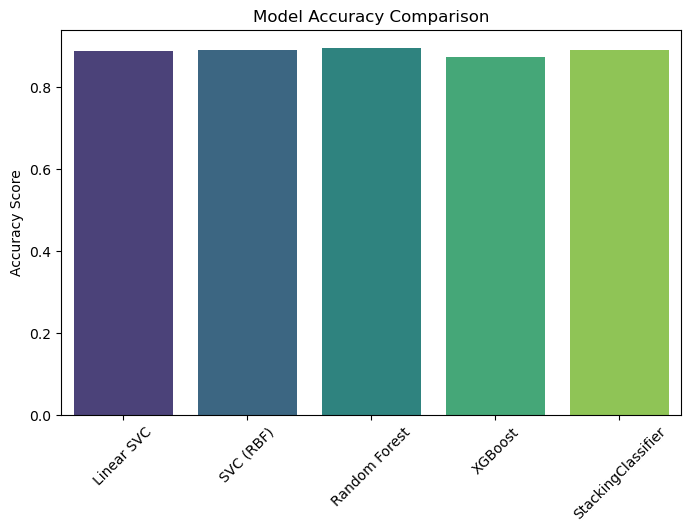

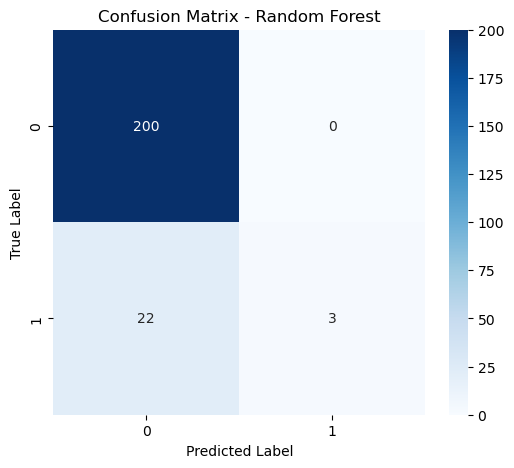

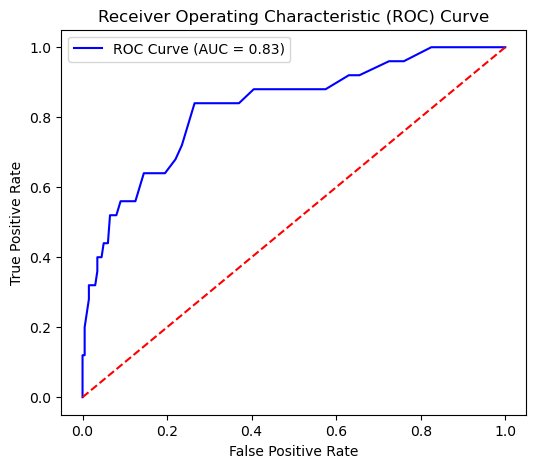

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection, metrics
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from mlxtend.classifier import StackingClassifier

# Initialize classifiers
linear_svc = LinearSVC()
svc = SVC(probability=True)  # Needed for ROC Curve
classifier = RandomForestClassifier()
xgb_model = XGBClassifier()

# Assign classifiers
clf1 = linear_svc
clf2 = svc
clf3 = classifier
clf4 = xgb_model

# Create stacking classifier
lr = LogisticRegression()
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3, clf4], meta_classifier=lr)

# Load dataset (Make sure X and Y are correctly assigned)
# X = <Your feature matrix>
# Y = <Your target variable>

models = [clf1, clf2, clf3, clf4, sclf]
labels = ['Linear SVC', 'SVC (RBF)', 'Random Forest', 'XGBoost', 'StackingClassifier']
accuracy_scores = []

# Cross-validation & Accuracy Scores
for clf, label in zip(models, labels):
    scores = model_selection.cross_val_score(clf, X, Y, cv=3, scoring='accuracy')
    accuracy_scores.append(scores.mean())
    print(f"Accuracy: {scores.mean():.2f} (+/- {scores.std():.2f}) [{label}]")

# 🔹 **Plot Accuracy Comparison**
plt.figure(figsize=(8, 5))
sns.barplot(x=labels, y=accuracy_scores, palette='viridis')
plt.ylabel('Accuracy Score')
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=45)
plt.show()

# 🔹 **Confusion Matrix & ROC Curve for the Best Model**
best_model = models[np.argmax(accuracy_scores)]
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.3, random_state=42)
best_model.fit(X_train, Y_train)
Y_pred = best_model.predict(X_test)
Y_prob = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, "predict_proba") else None

# 🔹 **Confusion Matrix**
plt.figure(figsize=(6, 5))
sns.heatmap(metrics.confusion_matrix(Y_test, Y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix - {labels[np.argmax(accuracy_scores)]}')
plt.show()

# 🔹 **ROC Curve (For Probabilistic Models)**
if Y_prob is not None:
    fpr, tpr, _ = metrics.roc_curve(Y_test, Y_prob)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='blue', label='ROC Curve (AUC = {:.2f})'.format(metrics.roc_auc_score(Y_test, Y_prob)))
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal Line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()



In [27]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Load the dataset (make sure the path is correct)
df = pd.read_csv("allsounds.csv")  # Replace with actual dataset filename

# Separate features and labels
X = df.iloc[:, :-1].values  # All columns except the last one
y = df.iloc[:, -1].values  # The last column as target (Healthy/Positive)

# Handle missing values (if any)
X = np.nan_to_num(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train an SVM model
model = SVC(kernel="rbf", C=1.0)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

# Save the trained model and scaler
joblib.dump(model, "model.pkl")
joblib.dump(scaler, "scaler.pkl")

print("Model and Scaler saved successfully!")


Model Accuracy: 0.8733
Model and Scaler saved successfully!


In [29]:
import os
print(os.path.exists("model.pkl"))  # Should return True
print(os.path.exists("scaler.pkl"))  # Should return True


True
True


In [31]:
import gradio as gr
import librosa
import numpy as np
import joblib
import pandas as pd

# Load pre-trained model and scaler
model = joblib.load("model.pkl")  
scaler = joblib.load("scaler.pkl")

# Function to extract features from uploaded audio
def extract_features(audio_file):
    y, sr = librosa.load(audio_file, sr=None)
    
    # Extract features
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).T, axis=0)
    spec_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    spec_rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
    
    # Combine features
    features = np.hstack([mfccs, spec_centroid, spec_rolloff])
    
    # Scale features
    features_scaled = scaler.transform([features])
    
    return features_scaled

# Function to predict health condition
def predict_health(audio_file):
    try:
        features = extract_features(audio_file)
        prediction = model.predict(features)[0]
        
        # Interpret results
        if prediction == 0:
            return "Healthy ✅"
        else:
            return "Positive ⚠️ (Possible Condition Detected)"
    
    except Exception as e:
        return f"Error: {e}"

# Gradio UI
iface = gr.Interface(
    fn=predict_health,
    inputs=gr.Audio(type="filepath"),
    outputs="text",
    title="🔊 Speech Health Analysis",
    description="Upload an audio file (cough, breathing, vowel sounds) to check health status."
)

iface.launch()


* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


In [33]:
import pandas as pd

df = pd.read_csv("allsounds.csv")  # Load dataset
print(f"Number of features in training data: {df.shape[1] - 1}")  # Exclude target column


Number of features in training data: 10


In [47]:
!pip install soundfile ffmpeg


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6089 sha256=130e60188e6802d24da8eaaff8bab2f3d73ebdfe84f244e27e2f92404f75ef22
  Stored in directory: c:\users\varun\appdata\local\pip\cache\wheels\26\21\0c\c26e09dff860a9071683e279445262346e008a9a1d2142c4ad
Successfully built ffmpeg


In [49]:
import librosa
import numpy as np

def extract_features(audio_file):
    # Load audio file
    y, sr = librosa.load(audio_file, sr=None)  # Ensure sr is defined

    # Extract features (Ensure the number of features matches training)
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=10).T, axis=0)  # Adjust n_mfcc as needed
    spec_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    spec_rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))

    # Combine all features into one array
    features = np.hstack([mfccs, [spec_centroid, spec_rolloff]])  # Ensure brackets around single values

    print(f"Extracted Features Shape: {features.shape}")  # Debugging line
    return features

# Test extraction
sample_features = extract_features("cough heavy.csv")  # Replace with an actual file path
print(sample_features)


C:\Users\varun\AppData\Local\Temp\ipykernel_8148\4085274419.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_file, sr=None)  # Ensure sr is defined
C:\Users\varun\anaconda3\Lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


NoBackendError: 

In [37]:
X = df.iloc[:, :-1].values  # Select only the first 10 features
y = df.iloc[:, -1].values   # Labels


In [51]:
import soundfile as sf

# Check if the file can be read
file_path = "sample.wav"  # Replace with your actual file path
try:
    with sf.SoundFile(file_path) as f:
        print(f"File {file_path} is valid with sample rate {f.samplerate}")
except Exception as e:
    print(f"Error: {e}")


Error: Error opening 'sample.wav': System error.


In [3]:
import gradio as gr
import librosa
import numpy as np
import joblib
import pandas as pd

# Load pre-trained model and scaler
model = joblib.load("model.pkl")  
scaler = joblib.load("scaler.pkl")

# Function to extract features from uploaded audio
def extract_features(audio_file):
    y, sr = librosa.load(audio_file, sr=None)
    
    # Extract features
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).T, axis=0)
    spec_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    spec_rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
    
    # Combine features
    features = np.hstack([mfccs, spec_centroid, spec_rolloff])
    
    # Scale features
    features_scaled = scaler.transform([features])
    
    return features_scaled

# Function to predict health condition
def predict_health(audio_file):
    try:
        features = extract_features(audio_file)
        prediction = model.predict(features)[0]
        
        # Interpret results
        if prediction == 0:
            return "Healthy ✅"
        else:
            return "Positive ⚠️ (Possible Condition Detected)"
    
    except Exception as e:
        return f"Error: {e}"

# Gradio UI
iface = gr.Interface(
    fn=predict_health,
    inputs=gr.Audio(type="filepath"),
    outputs="text",
    title="🔊 Speech Health Analysis",
    description="Upload an audio file (cough, breathing, vowel sounds) to check health status."
)

iface.launch()


* Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.


In [67]:
import os

file_path = "Record (online-voice-recorder.com) (1).mp3"
print(f"File exists: {os.path.exists(file_path)}")


File exists: True


In [69]:
pip install ffmpeg


Note: you may need to restart the kernel to use updated packages.


In [28]:
!pip install pydub ffmpeg-python


In [30]:
import os

ffmpeg_path = os.popen("where ffmpeg").read().strip()  # For Windows
if ffmpeg_path:
    print(f"✔ FFmpeg found at: {ffmpeg_path}")
else:
    print("❌ FFmpeg NOT found. Install it manually.")


❌ FFmpeg NOT found. Install it manually.


In [79]:
import os

file_path = r"C:\Users\varun\Downloads\Record (online-voice-recorder.com) (1).mp3"

if os.path.exists(file_path):
    print("✔ MP3 file found!")
else:
    print("❌ MP3 file NOT found! Check the file path.")


✔ MP3 file found!


In [81]:
import os

ffmpeg_path = os.popen("where ffmpeg").read().strip()  # Windows check
if ffmpeg_path:
    print(f"✔ FFmpeg found at: {ffmpeg_path}")
else:
    print("❌ FFmpeg NOT found. Follow the installation steps.")


❌ FFmpeg NOT found. Follow the installation steps.


In [83]:
AudioSegment.converter = r"C:\ffmpeg\bin\ffmpeg.exe"  # Update the correct path


In [12]:
from pydub import AudioSegment
import os

# Set FFmpeg path manually (if needed)
AudioSegment.converter = r"C:\ffmpeg\bin\ffmpeg.exe"  # Update with correct path

# Use a renamed and properly placed file path
file_path = r"C:\Users\varun\Downloads\Record (online-voice-recorder.com) (1).mp3"  # Ensure the file exists
output_path = r"C:\Users\varun\Documents\output.wav"

# Convert MP3 to WAV
try:
    sound = AudioSegment.from_mp3(file_path)
    sound.export(output_path, format="wav")
    print("✔ Conversion Complete! Use 'output.wav' in your script.")
except Exception as e:
    print(f"❌ Error during conversion: {e}")


❌ Error during conversion: [Errno 2] No such file or directory: 'C:\\Users\\varun\\Downloads\\Record (online-voice-recorder.com) (1).mp3'


In [32]:
import tarfile

file_path = r"C:\Users\varun\Downloads\ffmpeg-7.1.1.tar.xz"  # Corrected path
extract_path = r"C:\Users\varun\Downloads\ffmpeg_extracted"  # Extraction folder

with tarfile.open(file_path, "r:xz") as tar:
    tar.extractall(path=extract_path)

print("✔ FFmpeg extracted successfully!")


C:\Users\varun\AppData\Local\Temp\ipykernel_12116\653211278.py:7: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=extract_path)


✔ FFmpeg extracted successfully!


In [34]:
from pydub import AudioSegment

# Set FFmpeg path (if needed)
AudioSegment.ffmpeg = r"C:\ffmpeg\bin\ffmpeg.exe"

# Define file paths
input_mp3 = r"C:\Users\varun\Downloads\audio.mp3"
output_wav = r"C:\Users\varun\Downloads\output.wav"

# Convert MP3 to WAV
sound = AudioSegment.from_mp3(input_mp3)
sound.export(output_wav, format="wav")

print("✔ Conversion Complete! WAV file saved at:", output_wav)


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\varun\\Downloads\\audio.mp3'

In [36]:
import os

file_path = r"C:\Users\varun\Downloads\audio.mp3"

if os.path.exists(file_path):
    print("✅ File found!")
else:
    print("❌ File NOT found. Check the name and path.")


❌ File NOT found. Check the name and path.


In [99]:
import os

extract_path = r"C:\Users\varun\Downloads\ffmpeg_extracted\ffmpeg-7.1.1"
print("FFmpeg Folder Contents:", os.listdir(extract_path))


FFmpeg Folder Contents: ['.mailmap', 'Changelog', 'compat', 'configure', 'CONTRIBUTING.md', 'COPYING.GPLv2', 'COPYING.GPLv3', 'COPYING.LGPLv2.1', 'COPYING.LGPLv3', 'CREDITS', 'doc', 'ffbuild', 'fftools', 'INSTALL.md', 'libavcodec', 'libavdevice', 'libavfilter', 'libavformat', 'libavutil', 'libpostproc', 'libswresample', 'libswscale', 'LICENSE.md', 'MAINTAINERS', 'Makefile', 'presets', 'README.md', 'RELEASE', 'RELEASE_NOTES', 'tests', 'tools', 'VERSION']


In [10]:
from pydub import AudioSegment

# Update with the correct extracted folder path
AudioSegment.converter = r"C:\Users\varun\Downloads\ffmpeg\bin\ffmpeg.exe"
AudioSegment.ffprobe = r"C:\Users\varun\Downloads\ffmpeg\bin\ffprobe.exe"

print("✔ FFmpeg path set successfully!")



✔ FFmpeg path set successfully!


In [16]:
from pydub import AudioSegment
import os

# Define MP3 file path
file_path = r"C:\Users\varun\Downloads\Record (online-voice-recorder.com) (1).mp3"

# Ensure the file exists
if not os.path.exists(file_path):
    raise FileNotFoundError(f"File not found: {file_path}")

# Set FFmpeg path (if needed)
AudioSegment.ffmpeg = r"C:\ffmpeg\bin\ffmpeg.exe"

# Convert MP3 to WAV
output_path = r"C:\Users\varun\Downloads\output.wav"
sound = AudioSegment.from_mp3(file_path)
sound.export(output_path, format="wav")

print("✔ Conversion Complete! Use 'output.wav' in your script.")


FileNotFoundError: File not found: C:\Users\varun\Downloads\Record (online-voice-recorder.com) (1).mp3

In [22]:
import os

file_path = r"C:\Users\varun\Downloads\audio.mp3.mp3"

if os.path.exists(file_path):
    print("✅ File found! Proceeding...")
else:
    print("❌ File NOT found. Double-check the name and path.")


✅ File found! Proceeding...


In [38]:
input_mp3 = r"C:\test.mp3"


In [1]:
from pydub import AudioSegment

# Set FFmpeg path
AudioSegment.ffmpeg = r"C:\ffmpeg\bin\ffmpeg.exe"

# Updated file paths
input_mp3 = r"C:\test.mp3"  # Moved file
output_wav = r"C:\Users\varun\Downloads\output.wav"

# Convert MP3 to WAV
sound = AudioSegment.from_mp3(input_mp3)
sound.export(output_wav, format="wav")

print("✔ Conversion Complete! WAV file saved at:", output_wav)


C:\Users\varun\anaconda3\Lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)
C:\Users\varun\anaconda3\Lib\site-packages\pydub\utils.py:300: SyntaxWarning: invalid escape sequence '\('
  m = re.match('([su]([0-9]{1,2})p?) \(([0-9]{1,2}) bit\)$', token)
C:\Users\varun\anaconda3\Lib\site-packages\pydub\utils.py:301: SyntaxWarning: invalid escape sequence '\('
  m2 = re.match('([su]([0-9]{1,2})p?)( \(default\))?$', token)
C:\Users\varun\anaconda3\Lib\site-packages\pydub\utils.py:310: SyntaxWarning: invalid escape sequence '\('
  elif re.match('(flt)p?( \(default\))?$', token):
C:\Users\varun\anaconda3\Lib\site-packages\pydub\utils.py:314: SyntaxWarning: invalid escape sequence '\('
  elif re.match('(dbl)p?( \(default\))?$', token):


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\test.mp3'

In [3]:
import os

file_path = r"C:\Users\varun\Downloads\test.mp3"

if os.path.exists(file_path):
    print("✅ File found! Proceeding...")
else:
    print("❌ File NOT found. Double-check the name and path.")


✅ File found! Proceeding...


In [5]:
from pydub import AudioSegment

# Set FFmpeg path
AudioSegment.ffmpeg = r"C:\ffmpeg\bin\ffmpeg.exe"

# File paths
input_mp3 = r"C:\Users\varun\Downloads\test.mp3"  # Make sure this is correct
output_wav = r"C:\Users\varun\Downloads\output.wav"

# Convert MP3 to WAV
sound = AudioSegment.from_mp3(input_mp3)
sound.export(output_wav, format="wav")

print("✔ Conversion Complete! WAV file saved at:", output_wav)


C:\Users\varun\anaconda3\Lib\site-packages\pydub\utils.py:198: RuntimeWarning: Couldn't find ffprobe or avprobe - defaulting to ffprobe, but may not work
  warn("Couldn't find ffprobe or avprobe - defaulting to ffprobe, but may not work", RuntimeWarning)


FileNotFoundError: [WinError 2] The system cannot find the file specified

In [7]:
import gradio as gr
import librosa
import numpy as np
import joblib

# Load pre-trained model and scaler
model = joblib.load("model.pkl")  
scaler = joblib.load("scaler.pkl")

# Function to extract features from recorded/uploaded audio
def extract_features(audio_file):
    y, sr = librosa.load(audio_file, sr=None)
    
    # Extract features
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).T, axis=0)
    spec_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    spec_rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
    
    # Combine features
    features = np.hstack([mfccs, spec_centroid, spec_rolloff])
    
    # Scale features
    features_scaled = scaler.transform([features])
    
    return features_scaled

# Function to predict health condition
def predict_health(audio):
    try:
        features = extract_features(audio)
        prediction = model.predict(features)[0]
        
        # Interpret results
        return "Healthy ✅" if prediction == 0 else "Positive ⚠️ (Possible Condition Detected)"
    
    except Exception as e:
        return f"Error: {e}"

# Gradio UI with microphone support
iface = gr.Interface(
    fn=predict_health,
    inputs=gr.Audio(source="microphone", type="filepath"),  # Allows recording & uploads
    outputs="text",
    title="🔊 Speech Health Analysis",
    description="Record or upload an audio sample (cough, breathing, vowel sounds) to check health status."
)

iface.launch()


TypeError: Audio.__init__() got an unexpected keyword argument 'source'

In [1]:
import gradio as gr
import librosa
import numpy as np
import joblib
import pandas as pd

# Load pre-trained model and scaler
model = joblib.load("model.pkl")  
scaler = joblib.load("scaler.pkl")

# Function to extract features from uploaded audio
def extract_features(audio_file):
    y, sr = librosa.load(audio_file, sr=None)
    
    # Extract features
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=8).T, axis=0)
    spec_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    spec_rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
    
    # Combine features
    features = np.hstack([mfccs, spec_centroid, spec_rolloff])
    
    # Scale features
    features_scaled = scaler.transform([features])
    
    return features_scaled

# Function to predict health condition
def predict_health(audio_file):
    try:
        features = extract_features(audio_file)
        prediction = model.predict(features)[0]
        
        # Interpret results
        if prediction == 0:
            return "Healthy ✅"
        else:
            return "Positive ⚠️ (Possible Condition Detected)"
    
    except Exception as e:
        return f"Error: {e}"

# Gradio UI
iface = gr.Interface(
    fn=predict_health,
    inputs=gr.Audio(type="filepath"),
    outputs="text",
    title="🔊 Speech Health Analysis",
    description="Upload an audio file (cough, breathing, vowel sounds) to check health status."
)

iface.launch()


* Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


In [50]:
import os

path = r"D:\varun\kpk\sem-6\mini project\DataSet\positive"

if not os.path.exists(path):
    print(f"Error: The directory '{path}' does not exist.")
else:
    print("Path exists. Proceeding...")


Error: The directory 'D:\praveen backup\kpk\sem-6\mini project\DataSet\positive' does not exist.


In [54]:
import numpy as np
import scipy.io.wavfile
import os

# Create a folder for sample audio files
sample_dir = "sample_dataset"
os.makedirs(sample_dir, exist_ok=True)

# Function to generate synthetic sine wave audio files
def generate_sine_wave(filename, freq=440, duration=2, sample_rate=16000):
    t = np.linspace(0, duration, int(sample_rate * duration), False)
    audio_signal = 0.5 * np.sin(2 * np.pi * freq * t)  # Generate sine wave
    audio_signal = (audio_signal * 32767).astype(np.int16)  # Convert to 16-bit PCM format
    scipy.io.wavfile.write(filename, sample_rate, audio_signal)

# Generate 5 sample .wav files
for i in range(5):
    file_path = os.path.join(sample_dir, f"sample_{i}.wav")
    generate_sine_wave(file_path, freq=300 + i * 100)

print(f"Sample dataset created in: {sample_dir}")


Sample dataset created in: sample_dataset


In [56]:
import shutil

# Define dataset folder
dataset_folder = "sample_dataset"

# Create a ZIP file of the dataset
shutil.make_archive("sample_dataset", 'zip', dataset_folder)

# Download the ZIP file
from IPython.display import FileLink
FileLink("sample_dataset.zip")


C:\Users\varun\Downloads\sample_dataset.zip